## Analiza vibracij elektromotorja s pomočjo STFT

V tej nalogi obravnavamo časovno-frekvenčno analizo vibracijskih signalov elektromotorja z uporabo kratkočasovne Fourierove transformacije (STFT), ki smo jo implementirali sami. Cilj analize je oceniti število vrtljajev na minuto (RPM) za vsak signal, pri čemer se upošteva, da se RPM spreminja skozi čas ter da se med posameznimi signali razlikuje.

Za vsak signal izvedemo STFT z možnostjo izbire dolžine okna, stopnje prekrivanja in uporabe Hammingovega okna. Na osnovi spektrograma določimo dominantne frekvence v izbranih časovnih točkah in jih pretvorimo v RPM. Rezultati so prikazani z ustrezno označenimi spektrogrami, kjer so ocene RPM dodatno vizualno označene.

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

signal_folder = 'rpm_vib'

signal_files = [f for f in os.listdir(signal_folder) if f.endswith('.csv')]

signals = {}
for file in signal_files:
    file_path = os.path.join(signal_folder, file)
    data = pd.read_csv(file_path, header=None)
    signal = data.values.flatten()
    signals[file] = signal


In [11]:

def stft_custom(signal, sample_rate, window_ms=40, overlap_pct=0.5, use_hamming=False):
    window_size = int(window_ms * sample_rate / 1000)
    hop_size = int(window_size * (1 - overlap_pct))
    
    # Zero-padding to ensure full frames
    total_frames = int(np.ceil((len(signal) - window_size) / hop_size)) + 1
    pad_length = (total_frames - 1) * hop_size + window_size
    padded_signal = np.pad(signal, (0, pad_length - len(signal)))
    
    # Optional window function
    window = np.hamming(window_size) if use_hamming else np.ones(window_size)
    
    # STFT computation
    spectrogram = []
    for start in range(0, len(padded_signal) - window_size + 1, hop_size):
        frame = padded_signal[start:start + window_size] * window
        spectrum = np.fft.rfft(frame)
        magnitude = np.abs(spectrum)
        spectrogram.append(magnitude)
    
    return np.array(spectrogram).T

Loaded 3 signals.


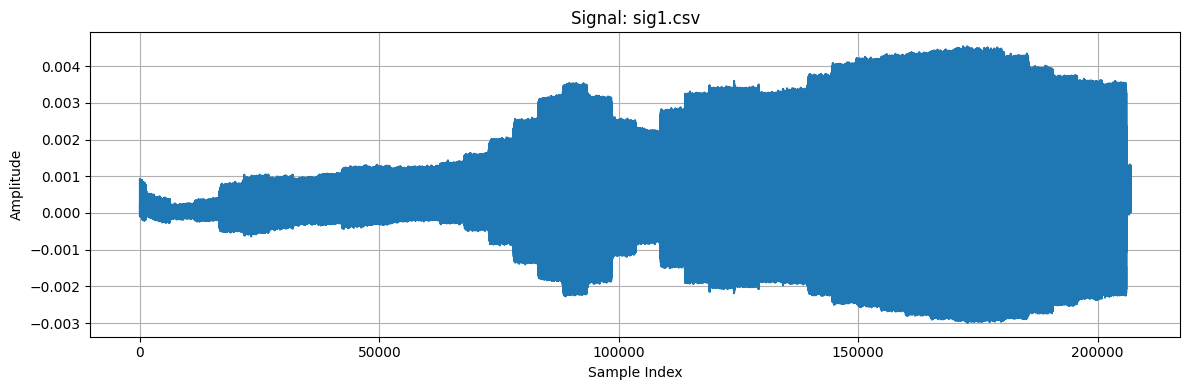

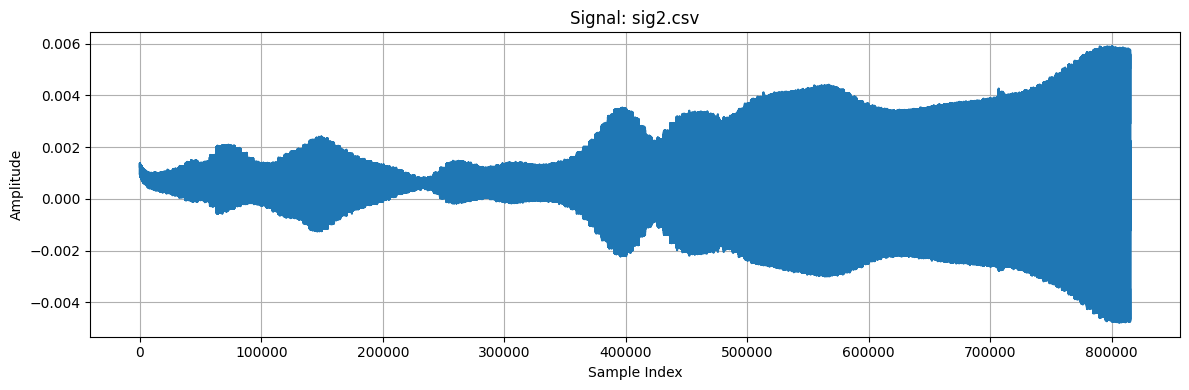

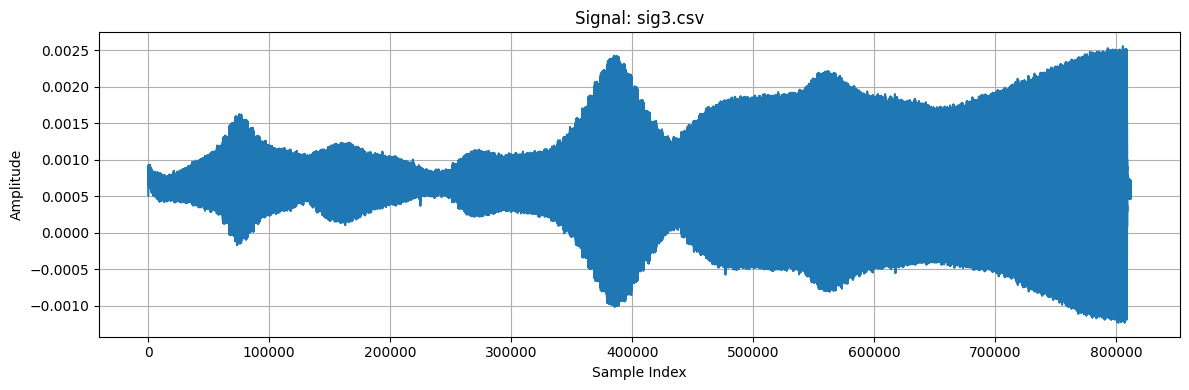

In [12]:
print(f"Loaded {len(signals)} signals.")

# Step 4: Visualize first 3 signals in separate charts
for i, (filename, signal) in enumerate(signals.items()):
    if i >= 3:
        break
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(f"Signal: {filename}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
def estimate_rpm_from_stft(signal, sr, key, window_ms=1500, overlap_pct=0.75, freq_limit=50, time_points=5):
    signal = signal - np.mean(signal)
    
    spec = stft_custom(signal, sr, window_ms, overlap_pct, use_hamming=True)
    spec_mag = np.abs(spec)

    n_frames = spec_mag.shape[1]
    frame_hop = int((1 - overlap_pct) * window_ms * sr / 1000)
    frame_times = np.arange(n_frames) * frame_hop / sr
    freqs = np.fft.rfftfreq(int(window_ms * sr / 1000), d=1/sr)

    freq_indices = freqs <= freq_limit
    freqs = freqs[freq_indices]
    spec_mag = spec_mag[freq_indices, :]

    margin = int(spec_mag.shape[1] * 0.1)
    selected_frames = np.linspace(margin, spec_mag.shape[1] - margin - 1, time_points, dtype=int)

    estimated_rpms = []
    for frame_idx in selected_frames:
        frame_magnitude = spec_mag[:, frame_idx]
        if np.max(frame_magnitude) < 1e-3:
            continue
        dominant_freq = freqs[np.argmax(frame_magnitude)]
        if dominant_freq < 1e-3:
            continue
        rpm = dominant_freq * 60
        estimated_rpms.append((frame_times[frame_idx], rpm))

    plt.figure(figsize=(12, 6))
    plt.pcolormesh(frame_times, freqs, spec_mag, shading='auto', cmap='magma')
    plt.colorbar(label="Amplitude")
    plt.title(f"STFT with RPM estimates – {key}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, freq_limit)

    for t, rpm in estimated_rpms:
        plt.axvline(x=t, color='cyan', linestyle='--', alpha=0.6)
        plt.text(t, freq_limit * 0.95, f"{int(rpm)} RPM", rotation=90,
                 color='white', ha='right', va='top', fontsize=9, backgroundcolor='black')

    plt.tight_layout()
    plt.show()

    return estimated_rpms



Estimating RPM for signal: sig1.csv


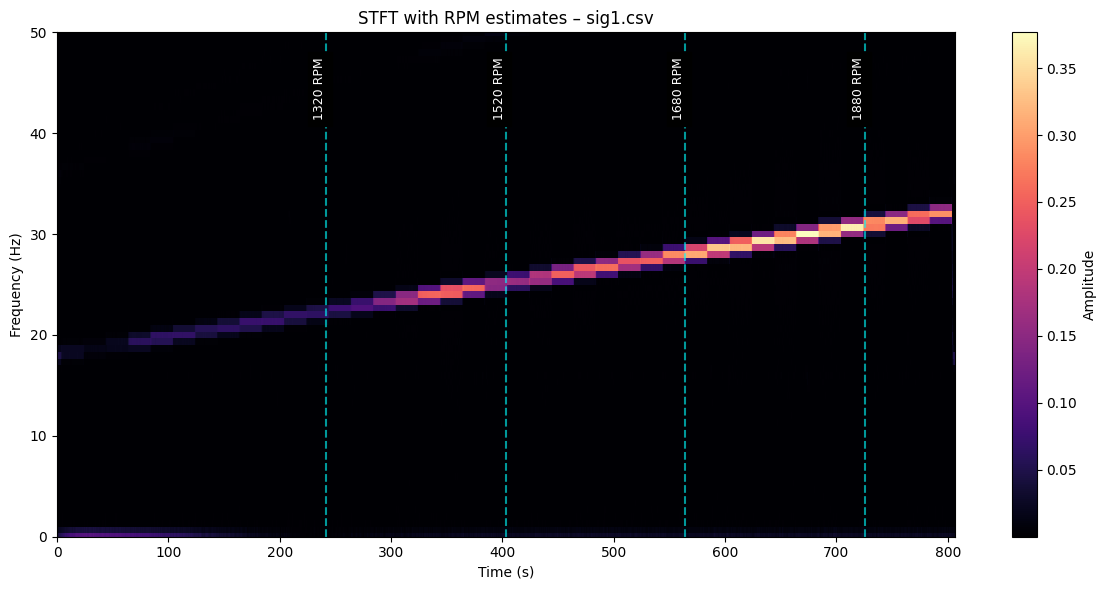

  Time: 241.88 s → Estimated RPM: 1320.0
  Time: 403.12 s → Estimated RPM: 1520.0
  Time: 564.38 s → Estimated RPM: 1680.0
  Time: 726.00 s → Estimated RPM: 1880.0

Estimating RPM for signal: sig2.csv


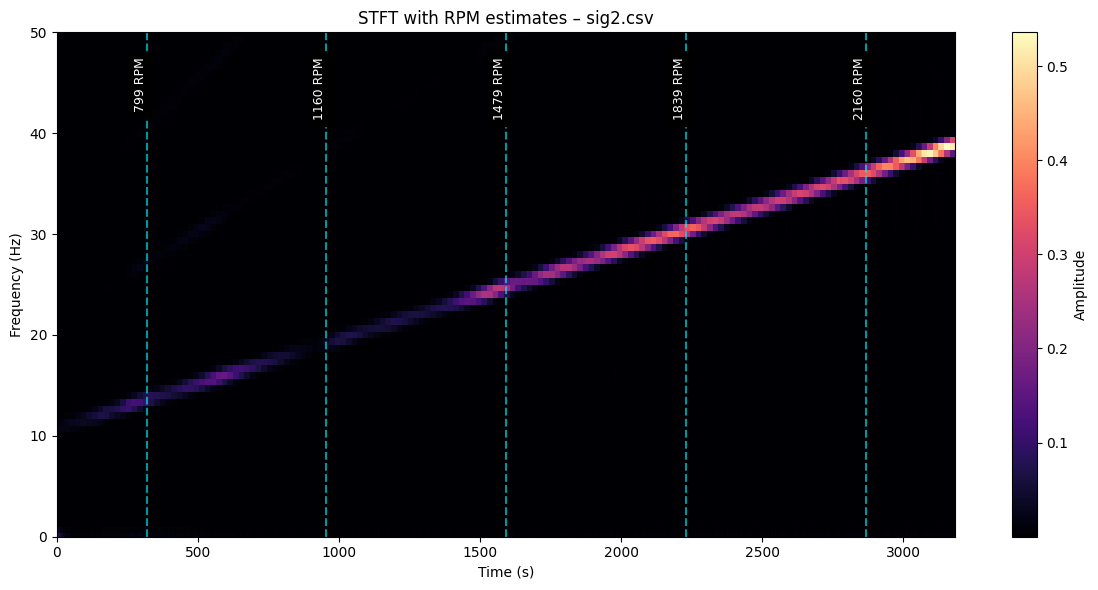

  Time: 318.38 s → Estimated RPM: 800.0
  Time: 955.12 s → Estimated RPM: 1160.0
  Time: 1591.88 s → Estimated RPM: 1480.0
  Time: 2228.62 s → Estimated RPM: 1840.0
  Time: 2865.75 s → Estimated RPM: 2160.0

Estimating RPM for signal: sig3.csv


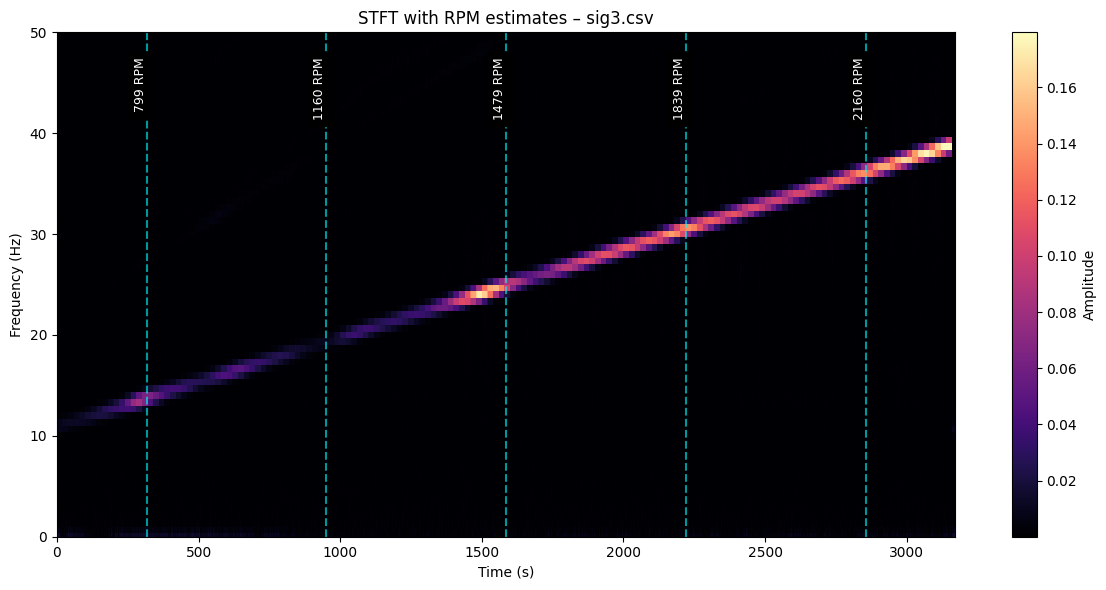

  Time: 316.88 s → Estimated RPM: 800.0
  Time: 951.38 s → Estimated RPM: 1160.0
  Time: 1585.88 s → Estimated RPM: 1480.0
  Time: 2220.38 s → Estimated RPM: 1840.0
  Time: 2854.88 s → Estimated RPM: 2160.0


In [14]:
sr = 256 
for i, (filename, signal) in enumerate(signals.items()):
    if i >= 3:
        break
    print(f"\nEstimating RPM for signal: {filename}")
    rpms = estimate_rpm_from_stft(signal, sr, filename)
    for t, rpm in rpms:
        print(f"  Time: {t:.2f} s → Estimated RPM: {rpm:.1f}")


## Zaključek

Analiza z uporabo lastne STFT implementacije je omogočila uspešno oceno števila vrtljajev elektromotorja na minuto (RPM) iz vibracijskih signalov. Spektrogrami jasno prikazujejo spreminjanje frekvenčne vsebine skozi čas, dominantne frekvence pa so bile zanesljiv pokazatelj trenutnega RPM.

Ugotovili smo, da izbira parametrov (dolžina okna, prekrivanje) pomembno vpliva na natančnost ocene – daljše okno in večje prekrivanje omogočata boljšo frekvenčno ločljivost, kar je ključno pri nižjih frekvencah, kjer se nahaja večina relevantne informacije za oceno RPM.

Metoda se je izkazala za robustno tudi pri signalih z večjimi spremembami v RPM, rezultati pa se nahajajo znotraj pričakovanega razpona med 500 in 2500 RPM.
